--- CHẠY TOÀN BỘ QUY TRÌNH ---
Đã tải ảnh: bien_so_xe.jpg (Kích thước: 685x513)
Bước 5.1: Tìm thấy 6 contours ban đầu.
Bước 5.2 (Lọc diện tích): Ngưỡng Min=1757 px, Max=28112 px
    -> Còn lại 2 contours.
Bước 5.3 (Lọc tỷ lệ): Vuông (1.5-2.5), Dài (3.5-5.0)
    -> Ứng cử viên cuối cùng: 2.


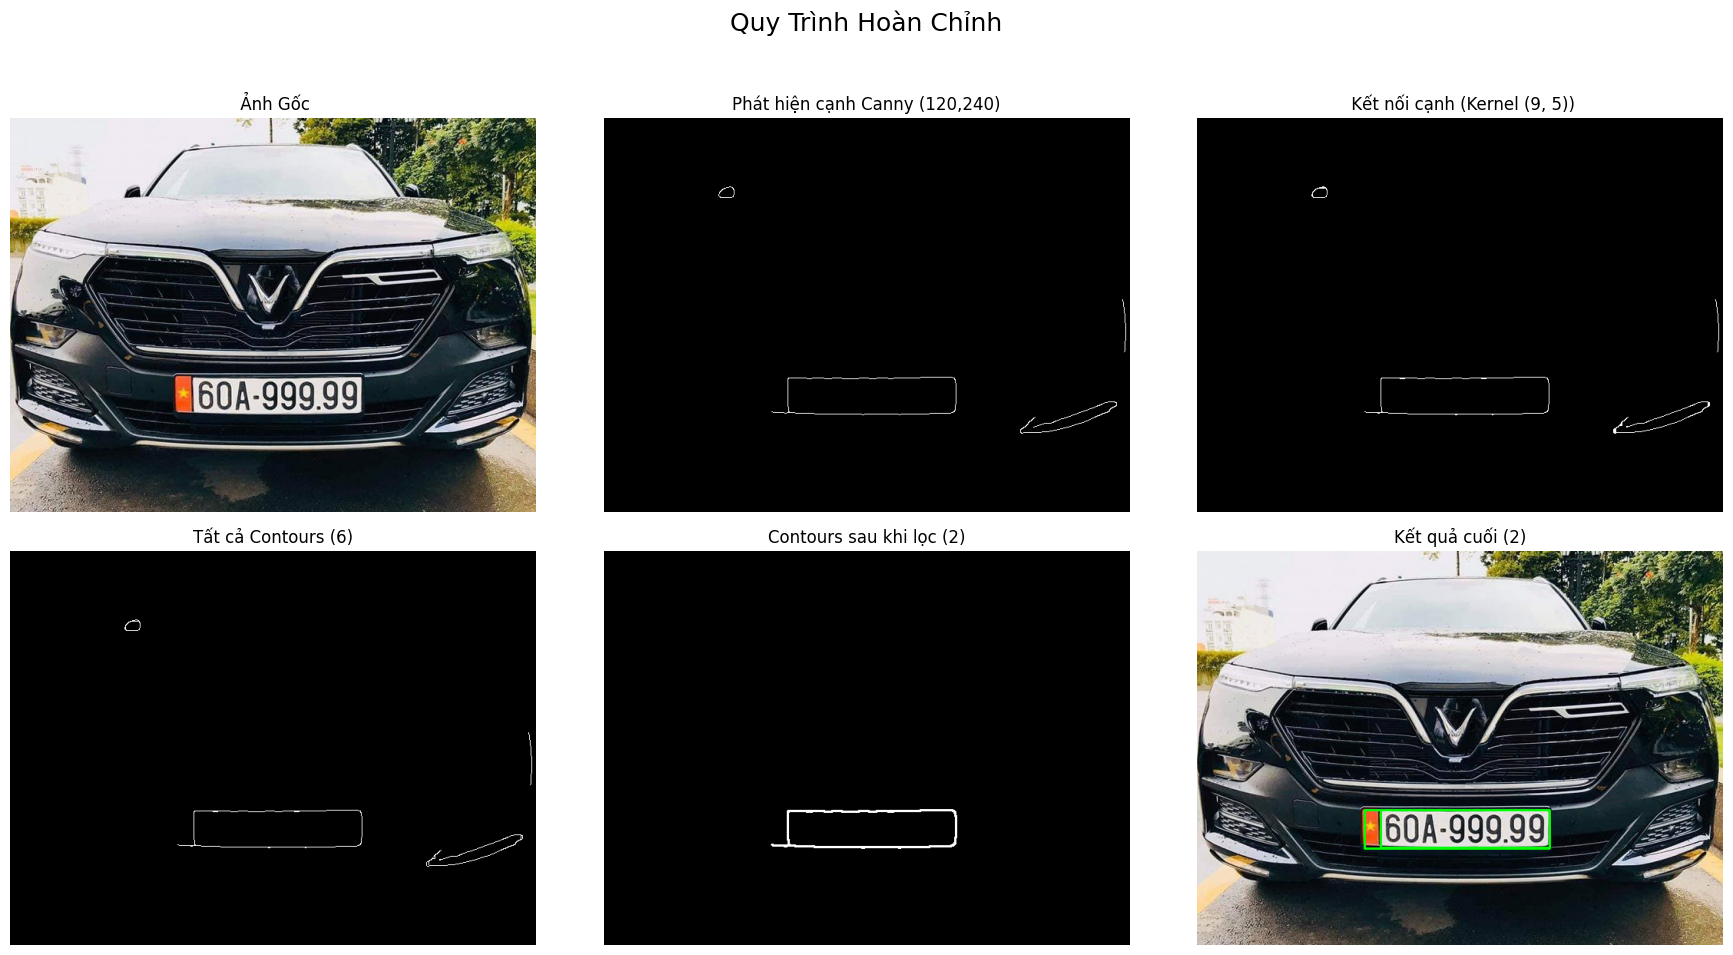

In [9]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# ==========================================================
# ===== TIỀN XỬ LÝ (GRAYSCALE + BLUR)
# ==========================================================
def tien_xu_ly(image):
    # Chuyển ảnh sang ảnh xám và làm mờ Gaussian.
    if len(image.shape) == 3 and image.shape[2] == 3:
        gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_image = image
    blurred_image = cv2.GaussianBlur(gray_image, (15, 15), 0)
    return blurred_image

# ==========================================================
# ===== PHÁT HIỆN CẠNH (CANNY)
# ==========================================================
def phat_hien_canh_canny(path_img, pairs=None, save_dir="/"):
    if pairs is None:
        pairs = [(30, 90), (120, 240)]

    # Đọc & đảm bảo xám + làm mờ
    img = cv2.imread(path_img, cv2.IMREAD_UNCHANGED)
    if img is None:
        raise FileNotFoundError(f"Không tìm thấy ảnh: {path_img}")
    
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) if (len(img.shape) == 3 and img.shape[2] == 3) else img
    blur = cv2.GaussianBlur(gray, (15, 15), 0)

    # Hiển thị ảnh mờ tham chiếu
    plt.figure(figsize=(5, 4))
    plt.imshow(blur, cmap='gray')
    plt.title(f"Blur: {Path(path_img).name}")
    plt.axis('off')
    plt.show()

    # Chạy các cặp ngưỡng
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    outs = []
    edges_list = []
    
    for t1, t2 in pairs:
        edges = cv2.Canny(blur, t1, t2, apertureSize=3, L2gradient=True)
        out = save_dir / f"{Path(path_img).stem}_edges_{t1}_{t2}.png"
        cv2.imwrite(str(out), edges)
        outs.append(str(out))
        edges_list.append(edges)
        
        plt.figure(figsize=(5, 4))
        plt.imshow(edges, cmap='gray')
        plt.title(f"{Path(path_img).name} - Canny ({t1},{t2})")
        plt.axis('off')
        plt.show()
        
    print("Đã lưu Canny edges:", *outs, sep="\n - ")
    return edges_list

# ==========================================================
# ===== KẾT NỐI CẠNH (MORPHOLOGY)
# ==========================================================
def ket_noi_canh(edge_img, kernel_size=(9, 5), shape='rect',
                  do_close=True, do_dilate=False, iterations=1):
    if edge_img is None:
        raise ValueError("Ảnh đầu vào rỗng hoặc không đọc được!")

    # Chuyển về nhị phân 0/255 (đảm bảo dạng chuẩn)
    if len(edge_img.shape) == 3:
        gray = cv2.cvtColor(edge_img, cv2.COLOR_BGR2GRAY)
    else:
        gray = edge_img.copy()
    binary = np.where(gray > 0, 255, 0).astype('uint8')

    # Tạo kernel (structuring element) theo lựa chọn
    if shape == 'rect':
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, kernel_size)
    elif shape == 'ellipse':
        kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    elif shape == 'cross':
        kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, kernel_size)
    else:
        raise ValueError("shape phải là 'rect', 'ellipse' hoặc 'cross'!")

    # Áp dụng phép đóng (closing = dilate -> erode)
    result = binary.copy()
    if do_close:
        result = cv2.morphologyEx(result, cv2.MORPH_CLOSE, kernel, iterations=iterations)

    # Chuẩn hóa đầu ra về 0/255
    result = np.where(result > 0, 255, 0).astype('uint8')
    return result

# ==========================================================
# ===== TÌM ỨNG CỬ VIÊN (FIND CONTOURS)
# ==========================================================
def tim_ung_cu_vien(anh_nhi_phan: np.ndarray):
    # Bảo đảm 1 kênh
    if len(anh_nhi_phan.shape) == 3:
        gray = cv2.cvtColor(anh_nhi_phan, cv2.COLOR_BGR2GRAY)
    else:
        gray = anh_nhi_phan.copy()
        
    # Nhị phân 0/255
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    
    # Tìm contours
    found = cv2.findContours(binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    contours = found[1] if len(found) == 3 else found[0]

    return contours, binary

# ==========================================================
# ===== LỌC ỨNG CỬ VIÊN
# ==========================================================
def loc_theo_dien_tich(contours, min_area, max_area):
    filtered_contours = []
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if min_area < area < max_area:
            filtered_contours.append(cnt)
    return filtered_contours

def loc_theo_ty_le_khung_hinh(contours, min_aspect_ratio_vuong=1.5, max_aspect_ratio_vuong=2.5,
                             min_aspect_ratio_dai=3.5, max_aspect_ratio_dai=5.0):
    ung_cu_vien_cuoi_cung = []
    for cnt in contours:
        # Lấy bounding box 
        x, y, w, h = cv2.boundingRect(cnt)
        if h == 0:
            continue   
        ty_le = float(w) / h
        
        # Kiểm tra xem có nằm trong ngưỡng của biển vuông (2 dòng)
        la_bien_vuong = (min_aspect_ratio_vuong < ty_le < max_aspect_ratio_vuong)
        
        # Kiểm tra xem có nằm trong ngưỡng của biển dài (1 dòng)
        la_bien_dai = (min_aspect_ratio_dai < ty_le < max_aspect_ratio_dai)
        
        if la_bien_vuong or la_bien_dai:
            ung_cu_vien_cuoi_cung.append(cnt)
            
    return ung_cu_vien_cuoi_cung

# ==========================================================
# ===== HÀM HỖ TRỢ: VẼ KẾT QUẢ
# ==========================================================
def ve_contours(contours, shape, thickness=1):
    h, w = shape[:2]
    canvas = np.zeros((h, w), dtype=np.uint8)
    cv2.drawContours(canvas, contours, -1, 255, thickness)
    return canvas

def ve_bounding_boxes(image, contours, color=(0, 255, 0), thickness=2):
    image_result = image.copy()
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        cv2.rectangle(image_result, (x, y), (x + w, y + h), color, thickness)
    return image_result

# ==========================================================
# ===== HÀM CHÍNH: CHẠY TOÀN BỘ QUY TRÌNH
# ==========================================================

if __name__ == "__main__":
    IMAGE_PATH = "bien_so_xe.jpg"
    # Làm mờ
    BLUR_KERNEL_SIZE = (15, 15) 
    # Ngưỡng Canny
    CANNY_THRESHOLD_1 = 120
    CANNY_THRESHOLD_2 = 240
    # Kernel kết nối
    CONNECT_KERNEL_SIZE = (9, 5) # Tốt cho biển số (ngang)
    # Cấu hình lọc
    MIN_AREA_RATIO = 0.005 # 0.5% diện tích ảnh
    MAX_AREA_RATIO = 0.08  # 8% diện tích ảnh

    # Lọc tỷ lệ khung hình (w/h)
    MIN_AR_VUONG = 1.5 # Biển vuông (2 dòng)
    MAX_AR_VUONG = 2.5
    MIN_AR_DAI = 3.5 # Biển dài (1 dòng)
    MAX_AR_DAI = 5.0
    
    print("--- CHẠY TOÀN BỘ QUY TRÌNH ---")

    try:
        # --- Đọc ảnh ---
        image_color = cv2.imread(IMAGE_PATH)
        if image_color is None:
            raise FileNotFoundError(f"Không thể tải ảnh: {IMAGE_PATH}")
        
        H, W = image_color.shape[:2]
        print(f"Đã tải ảnh: {IMAGE_PATH} (Kích thước: {W}x{H})")

        # --- Tiền xử lý (Xám + Làm mờ) ---
        blur = tien_xu_ly(image_color) # Hàm này đã bao gồm cả cvtColor

        # --- Phát hiện cạnh Canny ---
        edges = cv2.Canny(blur, CANNY_THRESHOLD_1, CANNY_THRESHOLD_2, 
                         apertureSize=3, L2gradient=True)

        # --- Kết nối cạnh ---
        connected_image = ket_noi_canh(edges, kernel_size=CONNECT_KERNEL_SIZE, 
                                       shape='rect', do_close=True, do_dilate=True)

        # --- Tìm tất cả contours ---
        contours_all, binary_used = tim_ung_cu_vien(connected_image)
        print(f"Bước 5.1: Tìm thấy {len(contours_all)} contours ban đầu.")

        # --- Lọc theo diện tích ---
        min_area_px = int(MIN_AREA_RATIO * W * H)
        max_area_px = int(MAX_AREA_RATIO * W * H)
        print(f"Bước 5.2 (Lọc diện tích): Ngưỡng Min={min_area_px} px, Max={max_area_px} px")
        
        contours_area_filtered = loc_theo_dien_tich(contours_all, min_area_px, max_area_px)
        print(f"    -> Còn lại {len(contours_area_filtered)} contours.")

        # --- Lọc theo tỷ lệ khung hình ---
        print(f"Bước 5.3 (Lọc tỷ lệ): Vuông ({MIN_AR_VUONG}-{MAX_AR_VUONG}), Dài ({MIN_AR_DAI}-{MAX_AR_DAI})")
        final_candidates = loc_theo_ty_le_khung_hinh(
            contours_area_filtered,
            min_aspect_ratio_vuong=MIN_AR_VUONG, max_aspect_ratio_vuong=MAX_AR_VUONG,
            min_aspect_ratio_dai=MIN_AR_DAI, max_aspect_ratio_dai=MAX_AR_DAI
        )
        print(f"    -> Ứng cử viên cuối cùng: {len(final_candidates)}.")
        
        # ---  Hiển thị kết quả ---
        canvas_all = ve_contours(contours_all, connected_image.shape, thickness=1)
        canvas_area_filtered = ve_contours(contours_area_filtered, connected_image.shape, thickness=2)
        # Vẽ kết quả cuối cùng lên ảnh gốc
        image_final_result = ve_bounding_boxes(image_color, final_candidates, color=(0, 255, 0), thickness=2)
        # Hiển thị
        fig, axes = plt.subplots(2, 3, figsize=(18, 10))
        fig.suptitle("Quy Trình Hoàn Chỉnh", fontsize=18)

        # Hàng 1
        axes[0, 0].imshow(cv2.cvtColor(image_color, cv2.COLOR_BGR2RGB))
        axes[0, 0].set_title(" Ảnh Gốc")
        axes[0, 0].axis('off')
        
        axes[0, 1].imshow(edges, cmap='gray')
        axes[0, 1].set_title(f"Phát hiện cạnh Canny ({CANNY_THRESHOLD_1},{CANNY_THRESHOLD_2})")
        axes[0, 1].axis('off')
        
        axes[0, 2].imshow(connected_image, cmap='gray')
        axes[0, 2].set_title(f" Kết nối cạnh (Kernel {CONNECT_KERNEL_SIZE})")
        axes[0, 2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95], h_pad=3.0)
        
        # Hàng 2
        axes[1, 0].imshow(canvas_all, cmap='gray')
        axes[1, 0].set_title(f"Tất cả Contours ({len(contours_all)})")
        axes[1, 0].axis('off')
        
        axes[1, 1].imshow(canvas_area_filtered, cmap='gray')
        axes[1, 1].set_title(f"Contours sau khi lọc ({len(contours_area_filtered)})")
        axes[1, 1].axis('off')
        
        axes[1, 2].imshow(cv2.cvtColor(image_final_result, cv2.COLOR_BGR2RGB))
        axes[1, 2].set_title(f"Kết quả cuối ({len(final_candidates)})")
        axes[1, 2].axis('off')

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except FileNotFoundError as e:
        print(f"LỖI: {e}")
        print(f"Vui lòng đảm bảo tệp '{IMAGE_PATH}' tồn tại trong cùng thư mục.")
    except ImportError:
        print("\n--- LỖI ---")
        print("Vui lòng cài đặt: pip install opencv-python matplotlib numpy")
    except Exception as e:
        print(f"\nĐã xảy ra lỗi không xác định: {e}")
